In [1]:
import numpy as np
import shutil
import pickle
import os
import librosa
import skimage.transform as st
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import collections

from utils import SAMPLE_RATE, SAMPLE_SIZE, mfsc, spike_encoding

dataset_dir = "dataset/"

load_order = []
with open('TIDIGITS_load_order.txt') as my_file:
    for line in my_file:
        load_order.append(line)
files = [f.rstrip() for f in load_order]
len(files)

4950

In [2]:
def plot_sound(sample, sample_rate=SAMPLE_RATE):
    #ipd.display(ipd.Audio(sample, rate=sample_rate))          
    duration = len(sample)/sample_rate
    time = np.arange(0,duration,1/sample_rate)
    plt.plot(time,sample)
    plt.show()

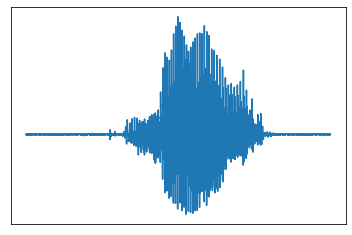

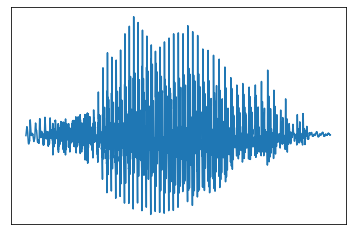

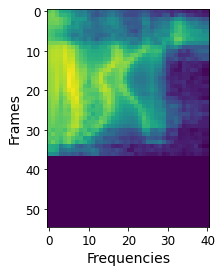

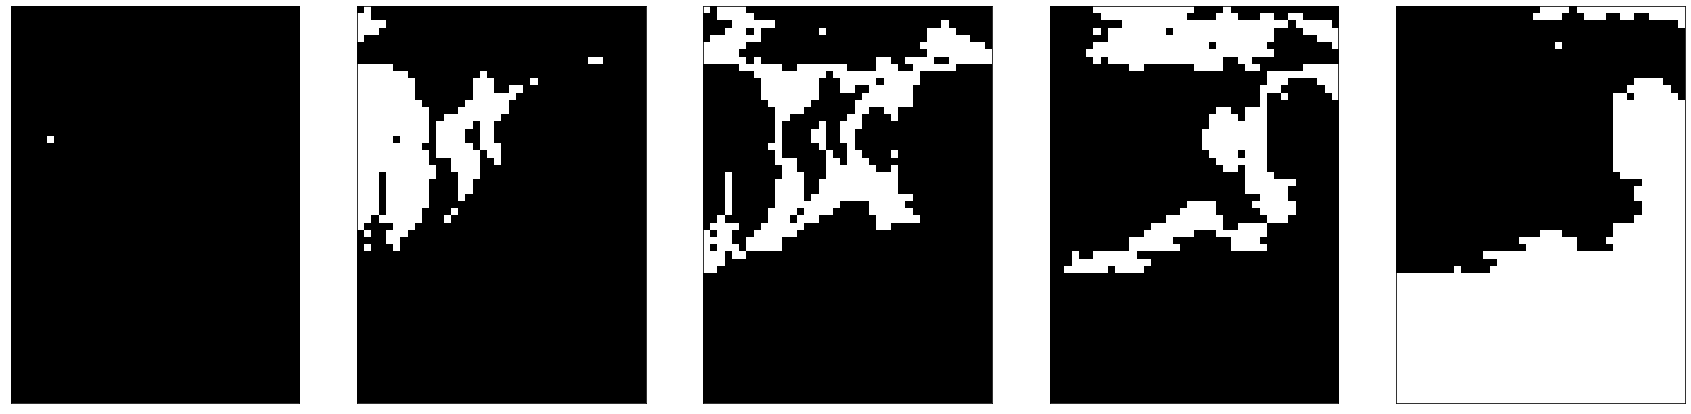

In [15]:
file = files[10]

# Load sample
sample, _ = librosa.load(dataset_dir + file, sr=SAMPLE_RATE)

fig = plt.figure()
duration = len(sample)/SAMPLE_RATE
time = np.arange(0,duration,1/SAMPLE_RATE)
plt.plot(time,sample)
fig.savefig('plots/components/signal.png', bbox_inches='tight')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

# Cut silence
sample = librosa.effects.trim(sample, top_db=20)[0]
fig = plt.figure()
duration = len(sample)/SAMPLE_RATE
time = np.arange(0,duration,1/SAMPLE_RATE)
plt.plot(time,sample)
fig.savefig('plots/components/signal_trimmed.png', bbox_inches='tight')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

# Padding to ensure samples have the same size
if len(sample) < SAMPLE_SIZE: sample = np.pad(sample, ((0,SAMPLE_SIZE-len(sample))), mode='constant')
# Convert sample into log melspectrogram
sample = mfsc(sample).T
fig = plt.figure()
s2 = np.ones((sample.shape[0],41))
s2[:,0:40] = sample
s2[:,40] = sample[:,39]
plt.imshow(s2)
plt.xlabel('Frequencies', fontsize=14)
plt.ylabel('Frames', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks([0,10,20,30,40], fontsize=12)
fig.savefig('plots/components/mfsc.png', bbox_inches='tight')
plt.show()

nb_timesteps = 5
encoded = spike_encoding(sample, nb_timesteps)
fig, axes = plt.subplots(nrows=1, ncols=nb_timesteps, figsize=(30,10))
for i in range(nb_timesteps):
    axes[i].imshow(encoded[i,0], cmap="gray")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig('plots/components/encoding.png', bbox_inches='tight')
plt.show()

[98.74747475 99.11784512 99.13804714 99.24579125 99.2996633  99.36026936
 99.42760943 99.36026936 99.36026936 99.43434343 99.41414141]


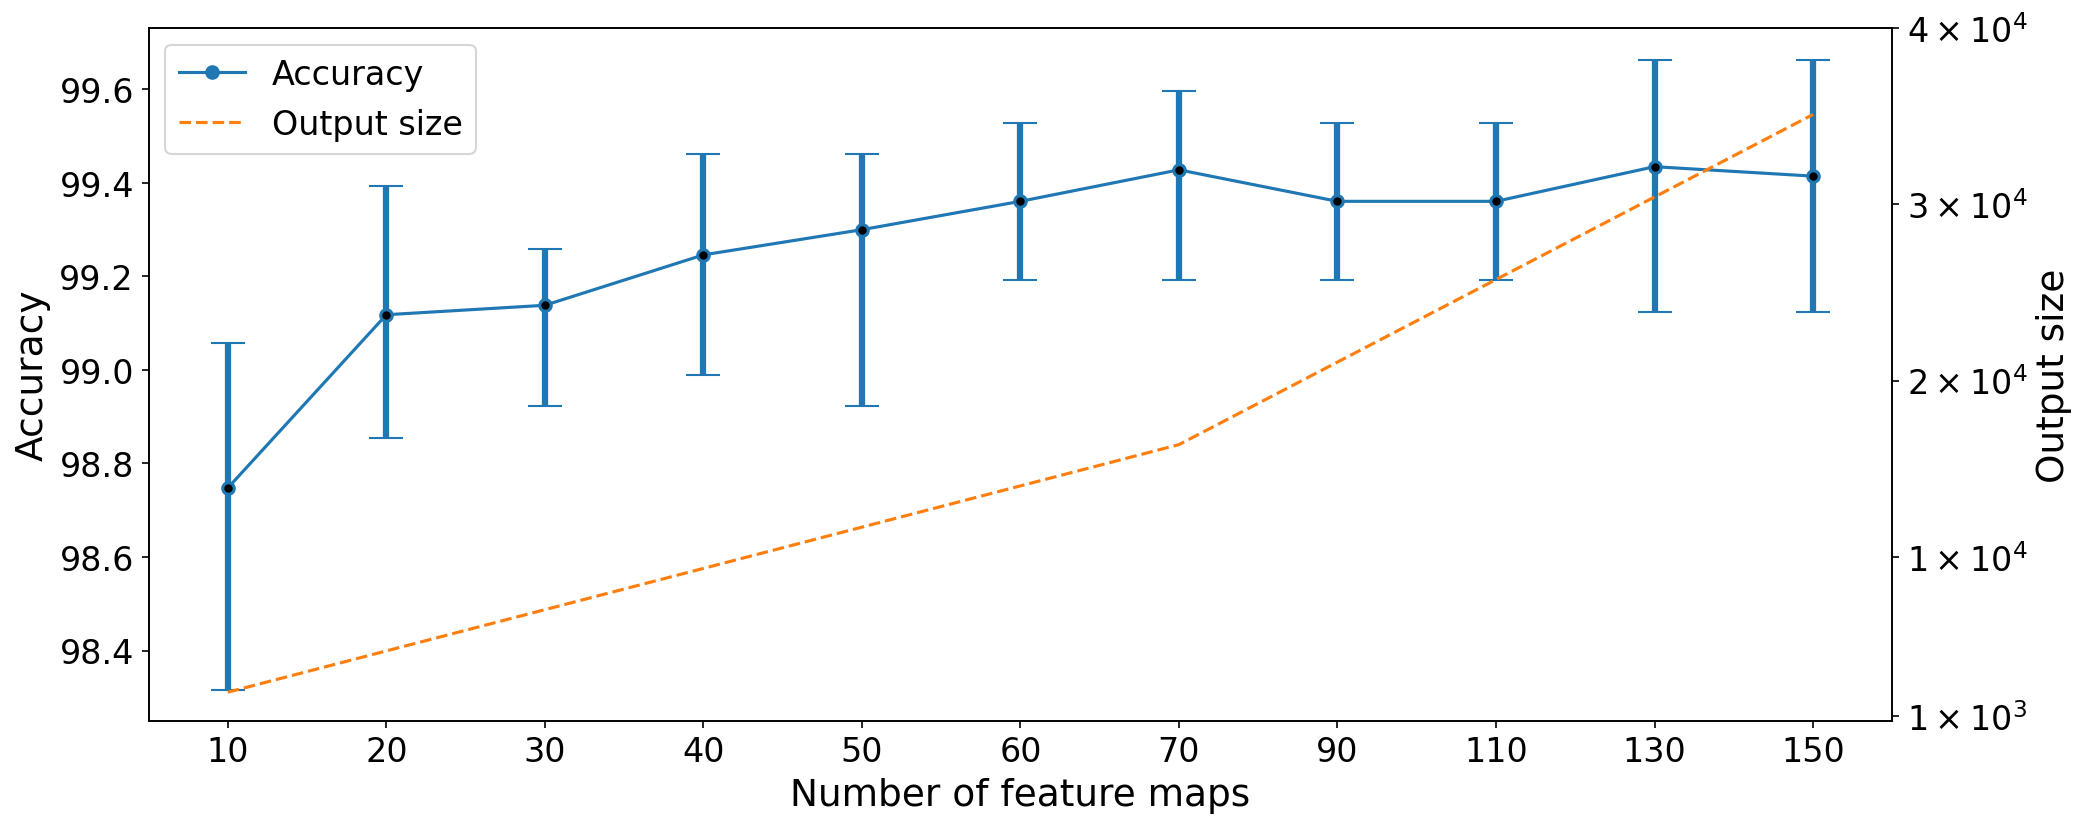

In [3]:
with open(f"logs/acc_vs_ft_maps.pkl", "rb") as input_file:
    acc_dict = pickle.load(input_file)

# Do not use the first value where nb_maps=5
x_axis = np.array(["10","20","30","40","50","60","70","90","110","130","150"]) #"5",
y1_axis = np.array([v for k, v in acc_dict.items()])[1:] * 100
# Output sizes manually computed
y2_axis = [2340,4680,7020,9360,11700,14040,16380,21060,25740,30420,35100] #1170,

mins = y1_axis.min(1)
maxes = y1_axis.max(1)
stds = y1_axis.std(1)
means = y1_axis.mean(1)
print(means)

fig, ax1 = plt.subplots(figsize=(15, 6), dpi=150)
ax1.tick_params(labelsize=16)
ax2 = ax1.twinx()
ax2.tick_params(labelsize=16)

p1 = ax1.plot(x_axis, means, "-o", label="Accuracy")
p2 = ax2.plot(x_axis, y2_axis, "--", color="#ff7f0e", label="Output size")

ax1.errorbar(x_axis, means, [means - mins, maxes - means],
         fmt='.k', ecolor='#1f77b4', lw=3, capsize=8)

p = p1 + p2
labs = [pp.get_label() for pp in p]
plt.legend(p, labs, fontsize=16)

ax1.set_xlabel('Number of feature maps', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax2.set_yticks([1000,10000,20000,30000,40000]) 
ax2.set_yticklabels([r"$1 \times 10^3$", r"$1 \times 10^4$", r"$2 \times 10^4$",  r"$3 \times 10^4$", r"$4 \times 10^4$"], fontsize=16)
ax2.set_ylabel('Output size', fontsize=18)

plt.savefig('plots/components/analysis_ft_maps.png', bbox_inches='tight')
plt.show()

[99.25252525 99.36026936 99.42760943 99.34006734 99.41414141 99.17171717]


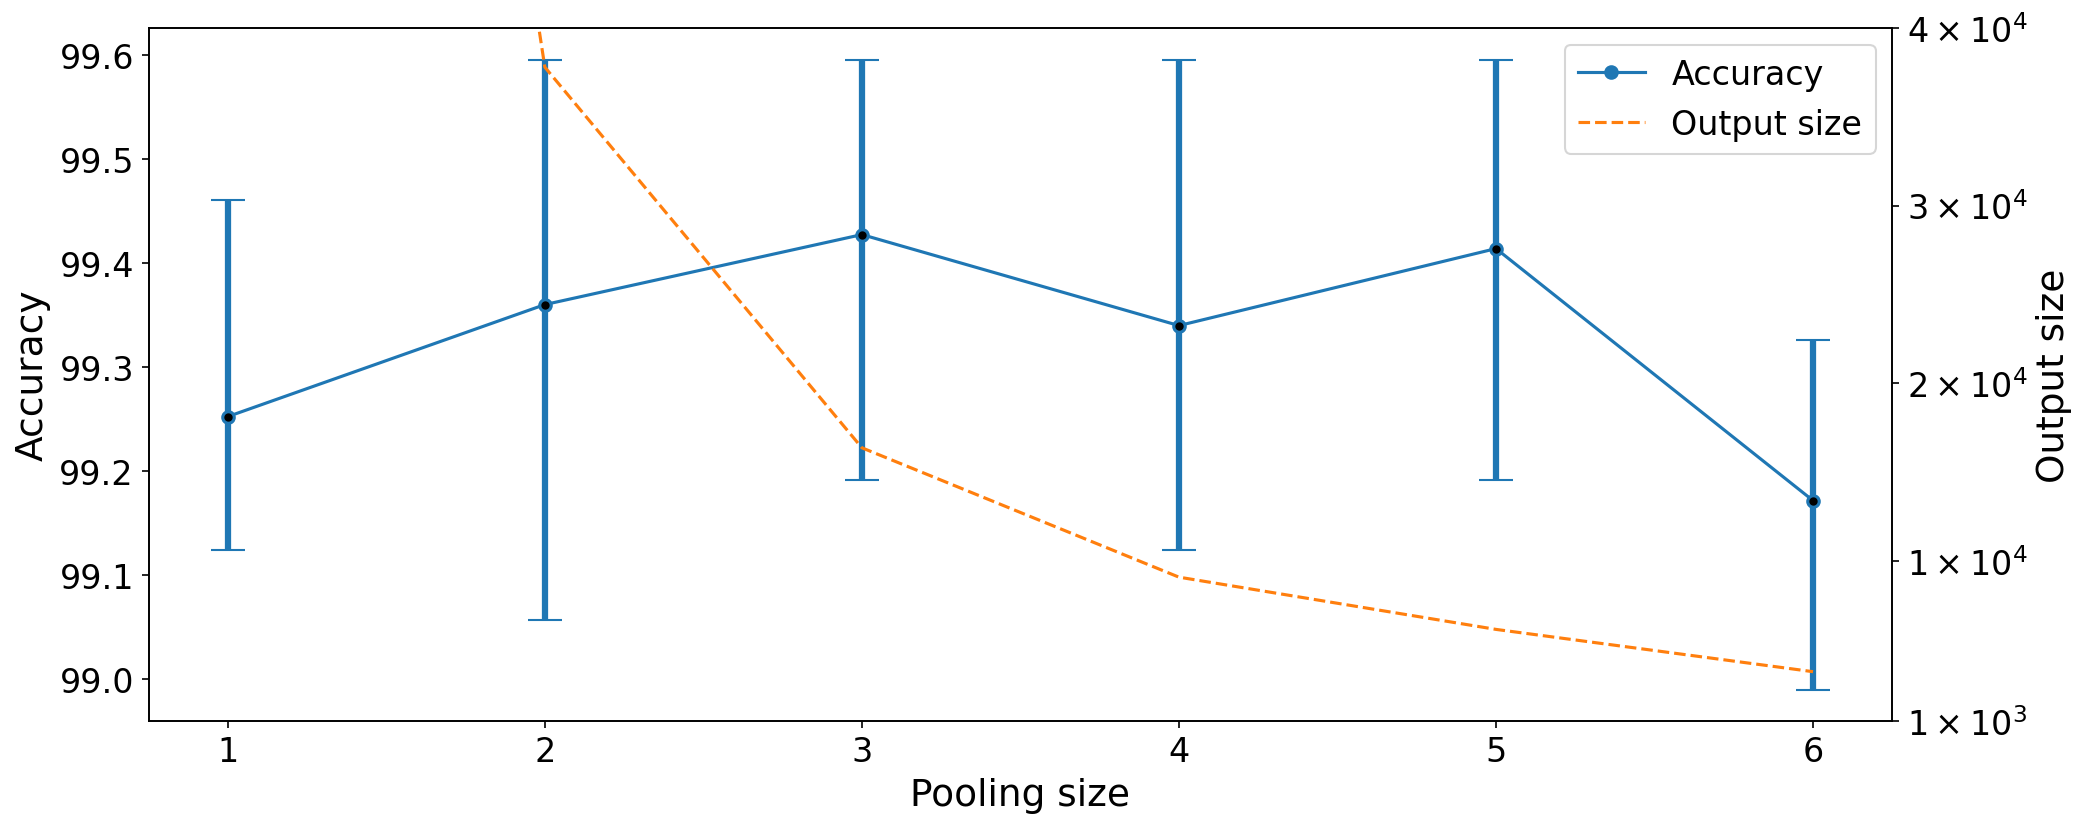

In [4]:
with open(f"logs/acc_vs_pooling.pkl", "rb") as input_file:
    acc_dict = pickle.load(input_file)

x_axis = np.array([i for i in range(1,7)])

y1_axis = np.array([v for k, v in acc_dict.items()]) * 100
# Output sizes manually computed
y2_axis = [154000, 37800, 16380, 9100, 6160, 3780]

mins = y1_axis.min(1)
maxes = y1_axis.max(1)
stds = y1_axis.std(1)
means = y1_axis.mean(1)

print(means)

fig, ax1 = plt.subplots(figsize=(15, 6), dpi=150)
ax1.tick_params(labelsize=16)
ax2 = ax1.twinx()
ax2.tick_params(labelsize=16)

p1 = ax1.plot(x_axis, means, "-o", label="Accuracy")
p2 = ax2.plot(x_axis, y2_axis, "--", color="#ff7f0e", label="Output size")

ax1.errorbar(x_axis, means, [means - mins, maxes - means],
         fmt='.k', ecolor='#1f77b4', lw=3, capsize=8)

p = p1 + p2
labs = [pp.get_label() for pp in p]
plt.legend(p, labs, fontsize=16)

ax1.set_xlabel('Pooling size', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax2.set_yticks([1000,10000,20000,30000,40000]) 
ax2.set_ylim([1000, 40000])
ax2.set_yticklabels([r"$1 \times 10^3$", r"$1 \times 10^4$", r"$2 \times 10^4$",  r"$3 \times 10^4$", r"$4 \times 10^4$"], fontsize=16)
ax2.set_ylabel('Output size', fontsize=18)

plt.savefig('plots/components/analysis_pooling_size.png', bbox_inches='tight')
plt.show()

[99.3        99.28619529 99.36026936 99.38047138 99.36026936 99.39393939
 99.36026936 99.2996633  99.31986532 99.34680135]
[444.4 515.8 349.3 276.  238.9 202.7 190.2 170.  159.2 154.5]


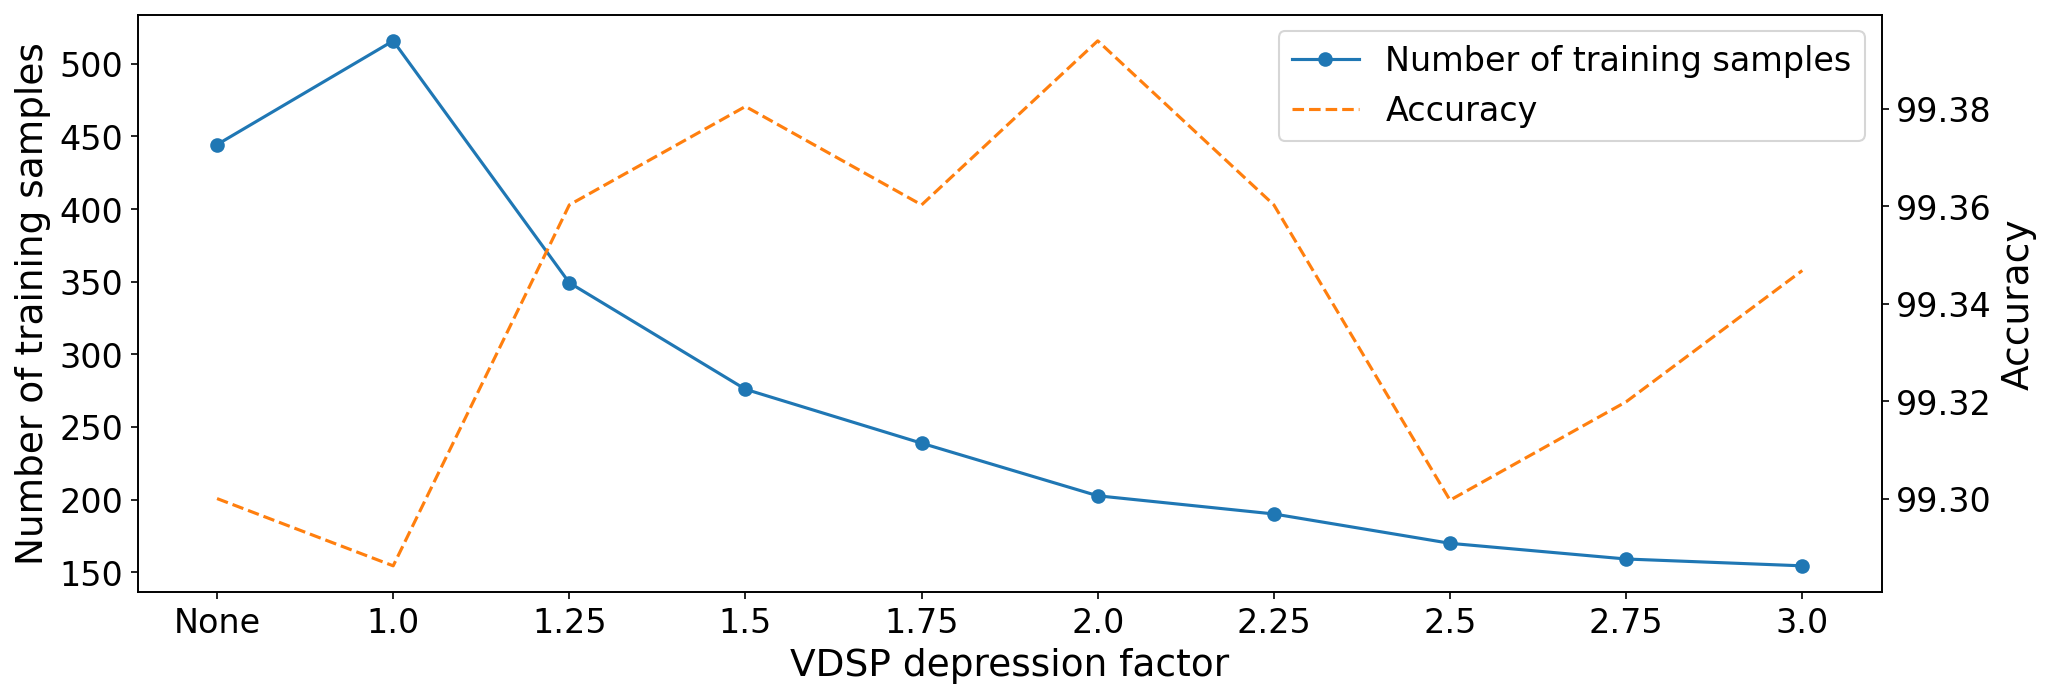

In [5]:
with open(f"logs/convergence_vs_vdsp_factor.pkl", "rb") as input_file:
    conv_dict = pickle.load(input_file)
    conv_dict[0] = np.ones((10))*444.4 # value computed without f_dep (V'pre - f_dep replaced by 1)
    
with open(f"logs/acc_vs_vdsp_factor.pkl", "rb") as input_file:
    acc_dict = pickle.load(input_file)
    acc_dict[0] = np.ones((10))*0.993 # value computed without f_dep V'pre - f_dep replaced by 1)

conv_dict = collections.OrderedDict(sorted(conv_dict.items()))
acc_dict = collections.OrderedDict(sorted(acc_dict.items()))

x_axis = np.array(["None"] + [str(1+0.25*i) for i in range(9)])
y1_axis = np.array([v for k, v in conv_dict.items()])
y1_axis = y1_axis.mean(1)
y2_axis = np.array([v for k, v in acc_dict.items()]) * 100

y2_axis = y2_axis.mean(1)
print(y2_axis)
print(y1_axis)
fig, ax1 = plt.subplots(figsize=(15, 5), dpi=150)
ax1.tick_params(labelsize=16)
ax2 = ax1.twinx()
ax2.tick_params(labelsize=16)

p1 = ax1.plot(x_axis, y1_axis, "-o", label="Number of training samples")
p2 = ax2.plot(x_axis, y2_axis, "--", color="#ff7f0e", label="Accuracy")

p = p1 + p2
labs = [pp.get_label() for pp in p]
plt.legend(p, labs, fontsize=16)

ax1.set_xlabel('VDSP depression factor', fontsize=18)
ax1.set_ylabel('Number of training samples', fontsize=18)
ax2.set_ylabel('Accuracy', fontsize=18)#, rotation=270)

ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig('plots/components/analysis_vdsp_factor.png', bbox_inches='tight')
plt.show()

[98.76767677 99.06397306 99.38047138 99.36700337 99.4006734  99.34006734
 99.28619529 99.28619529 99.27272727 99.25252525 99.26599327]


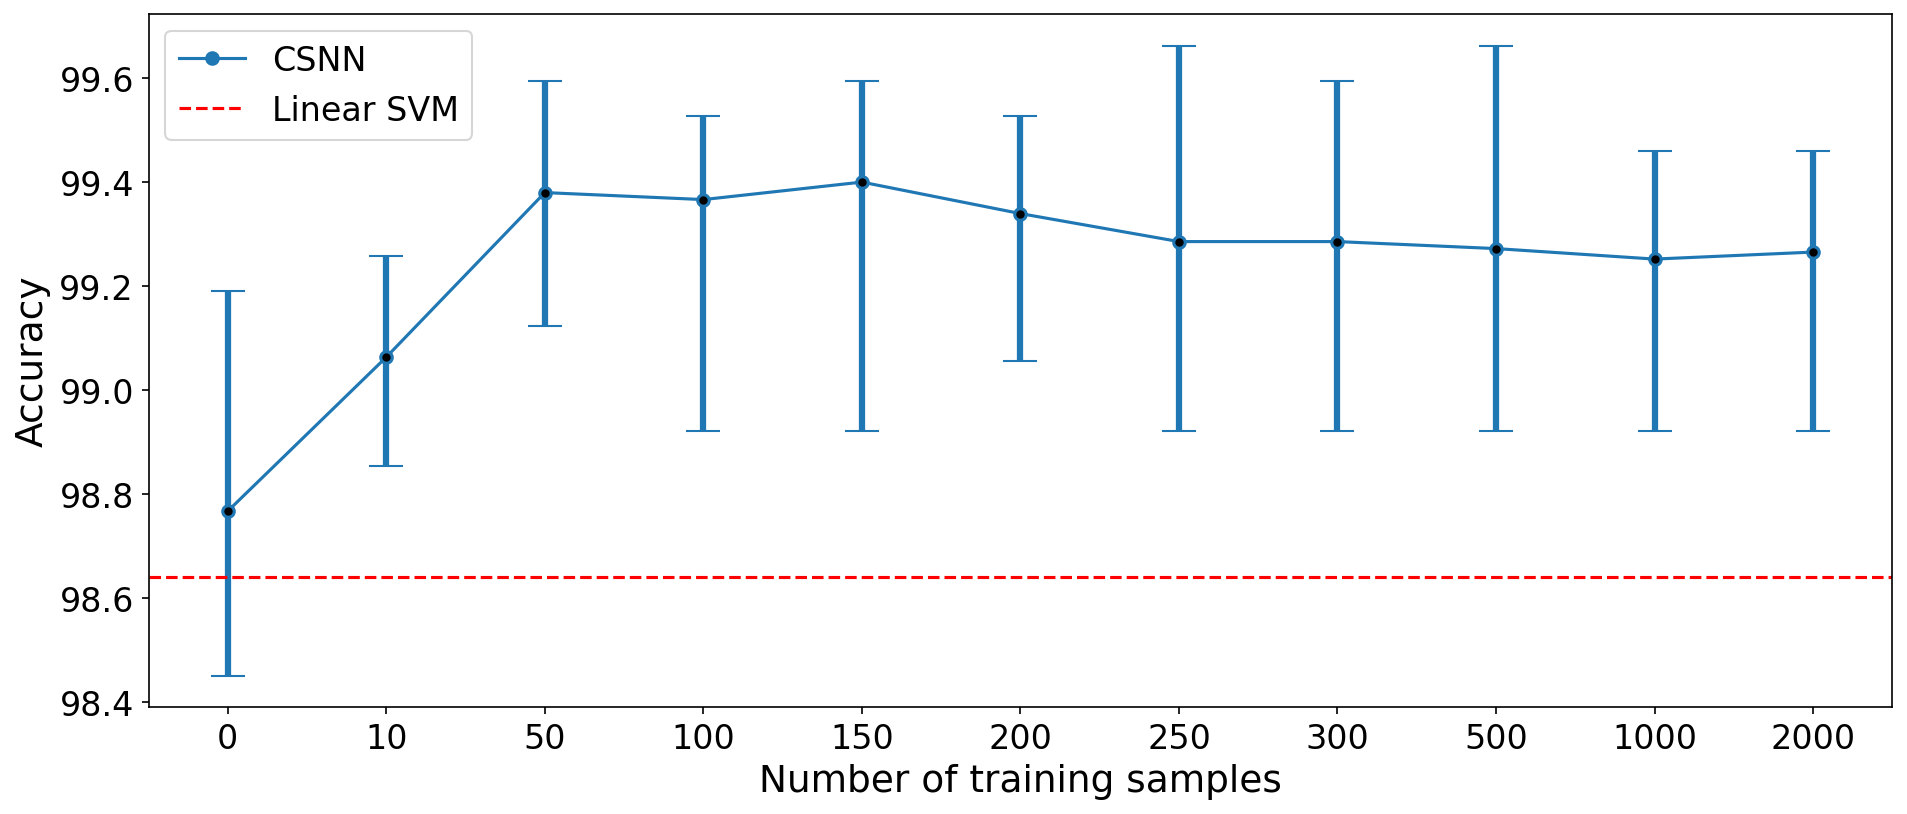

In [7]:
x_axis = ["0","10","50","100","150","200","250","300","500","1000","2000"]
fig = plt.figure(figsize=(15, 6), dpi=150)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Number of training samples', fontsize=18)

acc_dict = {}

# The code can be used to plot output for several learning rates
for lr in ['0.01_adaptive']:
    with open(f"logs/acc_vs_lr_{lr}.pkl", "rb") as input_file:
        acc_dict[lr] = pickle.load(input_file)

for lr in acc_dict.keys():
    y_axis = np.array([v for k, v in acc_dict[lr].items()]) * 100
    mins = y_axis.min(1)
    maxes = y_axis.max(1)
    stds = y_axis.std(1)
    means = y_axis.mean(1)
    print(means)
    plt.plot(x_axis, means, "-o", label=f"CSNN")
    plt.errorbar(x_axis, means, [means - mins, maxes - means],
         fmt='.k', ecolor='#1f77b4', lw=3, capsize=8)

acc_svm = 98.64
plt.axhline(y=acc_svm, color='r', linestyle='--', label="Linear SVM")
plt.legend(fontsize=16)
plt.savefig("plots/components/analysis_nb_training_samples.png")
plt.show()

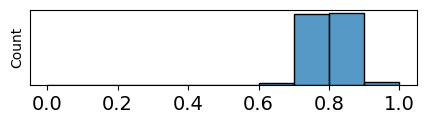

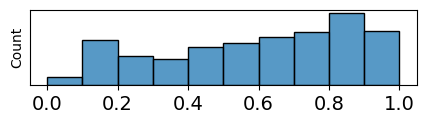

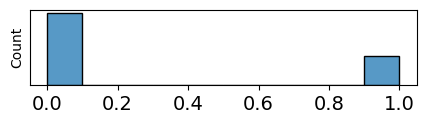

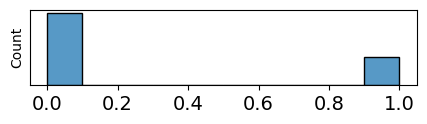

In [42]:
for nb_samples in [0,50,300]:
    plt.figure(figsize=(5, 1), dpi=100)
    weights = np.load(f"logs/weights/weights_{nb_samples}_samples.npy")
    sns.histplot(data=weights.flatten(), bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    plt.xticks(fontsize=14)
    plt.savefig(f"plots/components/hist_weights_{nb_samples}_training_samples.png", bbox_inches='tight', transparent=True)
    plt.yticks([])
    plt.show()